# Geospatial Analysis of Brazilian E-Commerce

Olist has released a dataset with 100k orders made between 2016 and 2018. Each order has some information about the customer and contains the first three digits of the customer zip code. Olist has also released a geolocation database that has 323k lat/lng coordinates related to the first three digits of each zip code.

We also published a full study, in Portuguese, about Brazilian logistics. [Read it here.](https://engineering.olist.com/por-que-suas-compras-online-atrasam-d4cf9df8c4d0)

## CEP: the Brazilian Zip Code
A brazilian zip code, also know as CEP, stands for Postal Adressing Code (*Código de Endereçamento Postal*) and contains 8 digits. Introduced in 1972 as a sequence of five digits, it was expanded to eight digits in 1992 to allow for more precise localization. The standard format is "nnnnn-nnn" (the original five digits, an hyphen, and the new three digits).

**CEP:** 12.345-678

Most cities with population around 100,000 and above have a CEP assigned to every public place and to some high-occupancy private spaces, like major commercial buildings and large residential condos. Small towns are assigned a general 5-digit code followed by the suffix -000. 

* the first part is composed by 5 digits that represent Region, Subregion, Sector, Subsector and Subsector Splitter.
* the second part contain 3 digits, separated by an hyphen from the first, and it represents the Distribution Identifiers.

More info about how CEP works may be found at the [Correios website](https://www.correios.com.br/a-a-z/cep-codigo-de-enderecamento-postal).

Lets look at the geolocation dataset provided by Olist and try to understand how CEP works geographically.

In [13]:
import numpy as np
import pandas as pd 
import os

geo = pd.read_csv("olist_geolocation_dataset.csv", dtype={'geolocation_zip_code_prefix': str})

# Gets the first three and four first digits of zip codes, we will explore this further to understand how zip codes works
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix'].str[0:1]
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix'].str[0:2]
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix'].str[0:3]
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix'].str[0:4]
geo.head(3)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   

  geolocation_city geolocation_state geolocation_zip_code_prefix_1_digits  \
0        sao paulo                SP                                    0   
1        sao paulo                SP                                    0   
2        sao paulo                SP                                    0   

  geolocation_zip_code_prefix_2_digits geolocation_zip_code_prefix_3_digits  \
0                                   01                                  010   
1                                   01                                  010   
2                                   01                                  010   

  geolocation_zip_code_prefix_4_digits  
0                                 0103  
1                                 0104  
2                                 0104

There are 19.051 different zip_code_prefix. On average there are 52.6 coordinates for each prefix. But there is one prefix with 1.146 coordinates available.

In [14]:
geo['geolocation_zip_code_prefix'].value_counts().to_frame().describe()

geolocation_zip_code_prefix
count                 19015.000000
mean                     52.598633
std                      72.057907
min                       1.000000
25%                      10.000000
50%                      29.000000
75%                      66.500000
max                    1146.000000

There are some outliers coordinates in the dataset that are outside of brazilian territory. Lets guarantee that all coordinates are within a rectangle delimited by the limits of Brazil.

In [15]:
# Removing some outliers
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]

In [16]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(geo.geolocation_lng, geo.geolocation_lat)
geo['x'] = pd.Series(x)
geo['y'] = pd.Series(y)

Then we treat the latitute and longitude coordinates and transform then to Mercator x/y Coordinates.

In [17]:
geo.head(3)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   

  geolocation_city geolocation_state geolocation_zip_code_prefix_1_digits  \
0        sao paulo                SP                                    0   
1        sao paulo                SP                                    0   
2        sao paulo                SP                                    0   

  geolocation_zip_code_prefix_2_digits geolocation_zip_code_prefix_3_digits  \
0                                   01                                  010   
1                                   01                                  010   
2                                   01                                  010   

  geolocation_zip_code_prefix_4_digits             x             y  
0                                 0103 -5.191862e+06 -2.698137e+06  
1                                 0104 -5.192478e+06 -2.698193e+06  
2                                 0104 -5.192270e+06 -2.698199e+06

## Zip Codes in Brazil
Finally plotting the coordinates on a map. We see there is a relationship between the zip code prefix and the location of that zip code. They start in Sao Paulo, with prefix 01001, and then increase counterclockwise finishing in Rio Grande do Sul (south of Brazil), with prefix 99990.

In [18]:
# transforming the prefixes to int for plotting purposes
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].astype(int)
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix_1_digits'].astype(int)
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix_2_digits'].astype(int)
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix_3_digits'].astype(int)
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix_4_digits'].astype(int)

In [19]:
brazil = geo
agg_name = 'geolocation_zip_code_prefix'
brazil[agg_name].describe().to_frame()

geolocation_zip_code_prefix
count                 1.000121e+06
mean                  3.657332e+04
std                   3.054939e+04
min                   1.001000e+03
25%                   1.107500e+04
50%                   2.653000e+04
75%                   6.350400e+04
max                   9.999000e+04

In [27]:
import geoviews.tile_sources as gvts
gvts.CartoDark

:WMTS   [Longitude,Latitude]

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
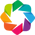

In [32]:
# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1

def plot_map(data, label, agg_data, agg_name, cmap):
#     url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gvts.CartoDark
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

In [33]:
brazil

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  \
0              sao paulo                SP   
1              sao paulo                SP   
2              sao paulo                SP   
3              sao paulo                SP   
4              sao paulo                SP   
...                  ...               ...   
1000158         tapejara                RS   
1000159   getulio vargas                RS   
1000160         tapejara                RS   
1000161  david canabarro                RS   
1000162         tapejara                RS   

         geolocation_zip_code_prefix_1_digits  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
1000158                                     9   
1000159                                     9   
1000160                                     9   
1000161                                     9   
1000162                                     9   

         geolocation_zip_code_prefix_2_digits  \
0                                           1   
1                                           1   
2                                           1   
3                                           1   
4                                           1   
...                                       ...   
1000158                                    99   
1000159                                    99   
1000160                                    99   
1000161                                    99   
1000162                                    99   

         geolocation_zip_code_prefix_3_digits  \
0                                          10   
1                                          10   
2                                          10   
3                                          10   
4                                          10   
...                                       ...   
1000158                                   999   
1000159                                   999   
1000160                                   999   
1000161                                   999   
1000162                                   999   

         geolocation_zip_code_prefix_4_digits             x             y  
0                                         103 -5.191862e+06 -2.698137e+06  
1                                         104 -5.192478e+06 -2.698193e+06  
2                                         104 -5.192270e+06 -2.698199e+06  
3                                         104 -5.191885e+06 -2.697988e+06  
4                                         103 -5.192120e+06 -2.697646e+06  
...                                       ...           ...           ...  
1000158                                  9995 -5.789805e+06 -3.257630e+06  
1000159                                  9990 -5.813647e+06 -3.233491e+06  
1000160                                  9995 -5.790252e+06 -3.258036e+06  
1000161                                 

In [34]:
plot_map(brazil, 'Zip Codes in Brazil', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (geolocation_zip_code_prefix)

In [31]:
# plot wtih datashader - image with black background
import datashader as ds
from datashader import transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from IPython.core.display import HTML, display
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr

background = "black"
cm = partial(colormap_select, reverse=(background!="black"))
export = partial(export_image, background = background, export_path="export")
display(HTML("<style>.container { width:100% !important; }</style>"))
W = 700 

def create_map(data, cmap, data_agg, export_name='img'):
    pad = (data.x.max() - data.x.min())/50
    x_range, y_range = ((data.x.min() - pad, data.x.max() + pad), 
                             (data.y.min() - pad, data.y.max() + pad))

    ratio = (y_range[1] - y_range[0]) / (x_range[1] - x_range[0])

    plot_width  = int(W)
    plot_height = int(plot_width * ratio)
    if ratio > 1.5:
        plot_height = 550
        plot_width = int(plot_height / ratio)
        
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

    agg = cvs.points(data, 'x', 'y', data_agg)
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    return export(img, export_name)

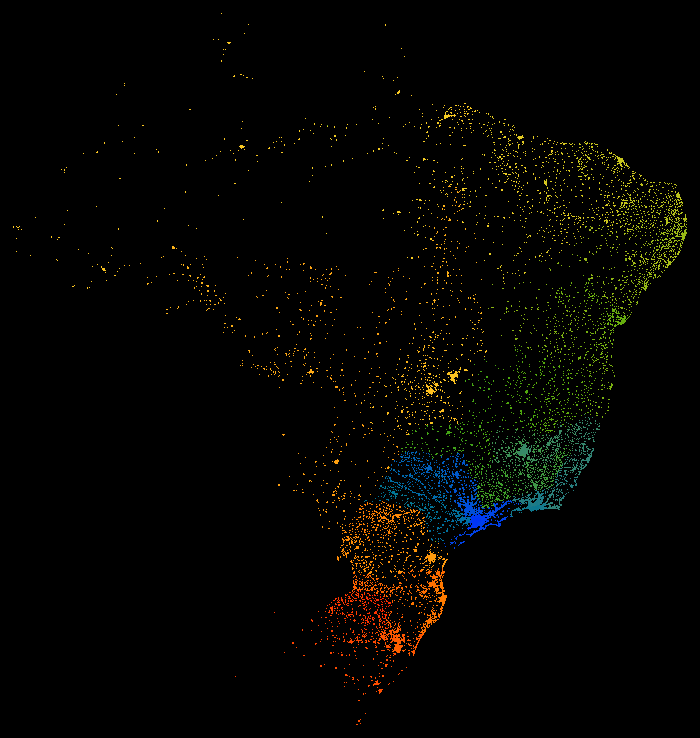

In [11]:
create_map(brazil, rainbow, ds.mean(agg_name),'brazil_zip_codes')

## Zip Codes in States
Lets look at the state of Sao Paulo (SP) to see how zip code prefixes works in a regional level. We see that:
* zip code prefixes in Sao Paulo state ranges from 01001 to 19990
* zip codes starting with 0 are in the Sao Paulo metro region
* zip codes starting with 1 are in the interior of the state

In [12]:
def filter_data(level, name):
    df = geo[geo[level] == name]
    #remove outliers
    df = df[(df.x <= df.x.quantile(0.999)) & (df.x >= df.x.quantile(0.001))]
    df = df[(df.y <= df.y.quantile(0.999)) & (df.y >= df.y.quantile(0.001))]
    return df

In [13]:
sp = filter_data('geolocation_state', 'SP')
agg_name = 'geolocation_zip_code_prefix'
sp[agg_name].describe().to_frame()

geolocation_zip_code_prefix
count                402651.000000
mean                   9030.831782
std                    5101.941134
min                    1001.000000
25%                    4661.000000
50%                    8257.000000
75%                   13330.000000
max                   19990.000000

In [14]:
plot_map(sp, 'Zip Codes in Sao Paulo State', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (geolocation_zip_code_prefix)

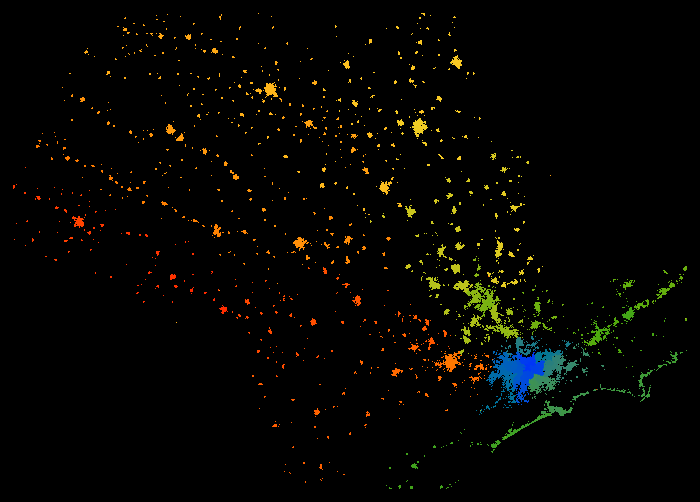

In [15]:
create_map(sp, rainbow, ds.mean(agg_name), 'sp_zip_codes')

## Zip Codes in Large Cities 
Lets look at the city of Sao Paulo to see how zip code prefixes works in a city level. We see that:
* zip code prefixes in Sao Paulo city ranges from 01001 to 09540
* zip code prefixes are somehow related to neighborhoods or city districts

In [16]:
saopaulo = filter_data('geolocation_city', 'sao paulo')
agg_name = 'geolocation_zip_code_prefix'
saopaulo[agg_name].describe().to_frame()

geolocation_zip_code_prefix
count                135256.000000
mean                   4137.454996
std                    1804.189554
min                    1001.000000
25%                    2941.000000
50%                    4166.000000
75%                    5158.000000
max                    9540.000000

In [17]:
plot_map(saopaulo, 'Zip Codes in Sao Paulo City', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (geolocation_zip_code_prefix)

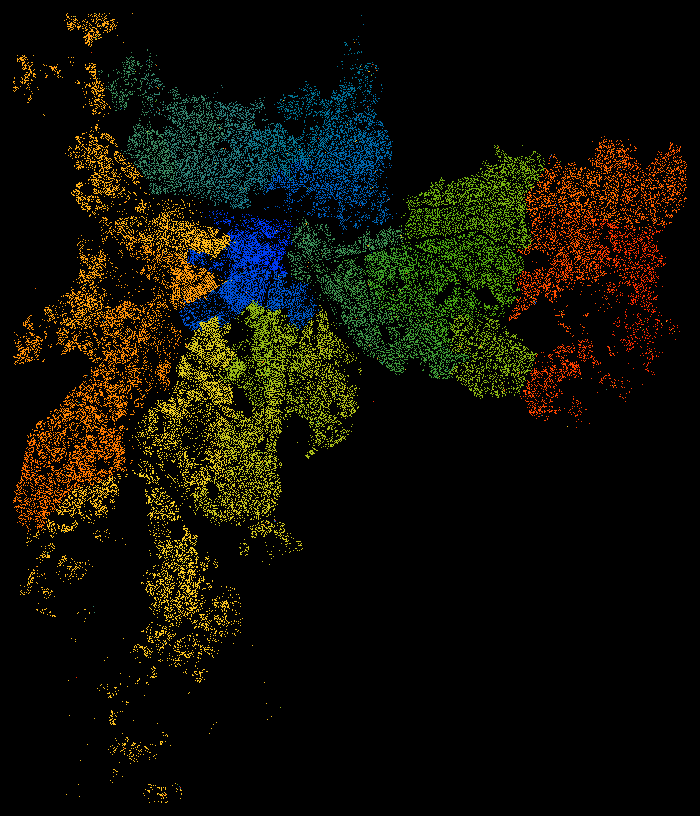

In [18]:
create_map(saopaulo, rainbow, ds.mean(agg_name), 'sao_paulo_zip_codes')

## Zip Codes in Small Cities
Lets look at the city of Atibaia to see how zip code prefixes works in a city level. We see that:
* zip code prefix of Atibaia city is between 12940 e 12954
* but there are other neighbor cities with the same zip code prefix
* to have more detail and go down to a city level we would probably need more zip code digits (the 4th and 5th digit)

In [19]:
atibaia = geo[geo['geolocation_city'] == 'atibaia']
agg_name = 'geolocation_zip_code_prefix'
atibaia[agg_name].describe().to_frame()

geolocation_zip_code_prefix
count                  1254.000000
mean                  12945.042265
std                       4.197704
min                   12940.000000
25%                   12942.000000
50%                   12944.000000
75%                   12948.000000
max                   12954.000000

In [20]:
plot_map(atibaia, 'Zip Codes in Atibaia', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (geolocation_zip_code_prefix)

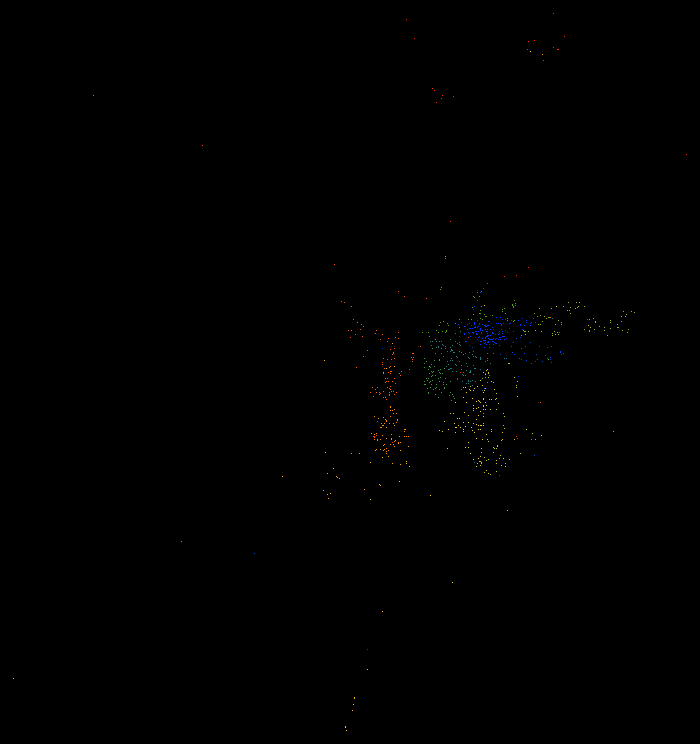

In [21]:
create_map(atibaia, rainbow, ds.mean(agg_name), 'atibaia_zip_codes')

## Abrangence of zip code digits
What does every digit in the zip code means? Lets zee how it behave, from 1 to 5 digits.

**Zip codes starting with 2 are all from Rio de Janeiro (RJ) and Espírito Santo (ES) States**

In [ ]:
# Zip code: 2
df = filter_data('geolocation_zip_code_prefix_1_digits', 2)
create_map(df, cm(Greys9), ds.count(), 'zip_code_2')

**Zip codes starting with 22 are all within the Rio de Janeiro City, but they represent multiple neighborhoods**

At the from right to left you see neighborhoods such as Leme, Copacabana, Ipanema, Leblon and Barra da Tijuca.

In [ ]:
# Zip code: 22
df = filter_data('geolocation_zip_code_prefix_2_digits', 22)
create_map(df, cm(Greys9), ds.count(), 'zip_code_22')

**Zip codes starting with 220 are all within Copacabana, a neighborhood of Rio de Janeiro**

In [ ]:
# Zip code: 220
df = filter_data('geolocation_zip_code_prefix_3_digits', 220)
create_map(df, cm(Greys9), ds.count(), 'zip_code_220')

**Zip codes starting with 2201 represent some streets of Copacabana**

In [ ]:
# Zip code: 2201
df = filter_data('geolocation_zip_code_prefix_4_digits', 2201)
create_map(df, cm(Greys9), ds.count(), 'zip_code_2201')

**Zip codes starting with 22010 represent a more strict set of streets of Copacabana**

In [ ]:
# Zip code: 22010
df = filter_data('geolocation_zip_code_prefix', 22010)
create_map(df, cm(Greys9), ds.count(), 'zip_code_22010')

So, now it should be clear to you that as we increase the quantity of numbers on zip codes we are selecting subsets of data.

# Where does most revenue comes from?
Working with 5 digits of zip codes might lead us to very small samples in some areas, so we will work with 3 digits. Plotting the sum of products value grouped by zip code prefix we see that most of the revenue came from the Southeast and South regions of Brazil. It is also possible to see that large cities and capitals, where population is bigger, have larger participation on revenue. 

In [ ]:
orders_df = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
customer = pd.read_csv('olist_customers_dataset.csv', dtype={'customer_zip_code_prefix': str})

# getting the first 3 digits of customer zipcode
customer['customer_zip_code_prefix_3_digits'] = customer['customer_zip_code_prefix'].str[0:3]
customer['customer_zip_code_prefix_3_digits'] = customer['customer_zip_code_prefix_3_digits'].astype(int)

brazil_geo = geo.set_index('geolocation_zip_code_prefix_3_digits').copy()

In [ ]:
# merging the data
orders = orders_df.merge(order_items, on='order_id')
orders = orders.merge(customer, on='customer_id')
orders = orders.merge(order_reviews, on='order_id')

In [ ]:
gp = orders.groupby('customer_zip_code_prefix_3_digits')['price'].sum().to_frame()
revenue = brazil_geo.join(gp)
agg_name = 'revenue'
revenue[agg_name] = revenue.price / 1000

In [ ]:
plot_map(revenue, 'Orders Revenue (thousands R$)', ds.mean(agg_name), agg_name, cmap=fire)

In [ ]:
create_map(revenue, fire, ds.mean(agg_name), 'revenue_brazil')

# What is the Average Ticket?
Here we see something somehow unexpected. Customers of the south and southeast regions of Brazil have lower average ticket, than their peers on north and norteast. This might happen because they have to pay more for freight (let's check that in a moment)

In [ ]:
gp = orders.groupby('order_id').agg({'price': 'sum', 'customer_zip_code_prefix_3_digits': 'max'})
gp = gp.groupby('customer_zip_code_prefix_3_digits')['price'].mean().to_frame()
avg_ticket = brazil_geo.join(gp)
agg_name = 'avg_ticket'
avg_ticket[agg_name] = avg_ticket.price

In [ ]:
plot_map(avg_ticket, 'Orders Average Ticket (R$)', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(avg_ticket, bgy, ds.mean('avg_ticket'), 'avg_ticket_brazil')

# Who pays more for transportation?
We might find a freight ratio by dividing the freight value by the order value. This ratio indicates the percentage of the product price that a person had to pay just to get their order delivered. For example, if a product costs R\$50.00 and the freight value was R\$10.00, then the freight ratio is 0.2 or 20%. Higher freight ratios are very likely to discourage customers to complete a purchase. Due to logistics costs, we expect to see lower freight ratios in densely populated areas and are higher freight ratios on sparsely poulated regions.

In [ ]:
gp = orders.groupby('order_id').agg({'price': 'sum', 'freight_value': 'sum', 'customer_zip_code_prefix_3_digits': 'max'})
agg_name = 'freight_ratio'
gp[agg_name] = gp.freight_value / gp.price
gp = gp.groupby('customer_zip_code_prefix_3_digits')[agg_name].mean().to_frame()
freight_ratio = brazil_geo.join(gp)

In [ ]:
plot_map(freight_ratio, 'Orders Average Freight Ratio', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(freight_ratio, bgy, ds.mean('freight_ratio'), 'freight_ratio_brazil')

# Average Delivery Time
Unfortunately, who lives in the north and northeast of Brazil has to bear with higher freight costs and has to wait longer to receive their purchase.

In [ ]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date)
orders['actual_delivery_time'] = orders.order_delivered_customer_date - orders.order_delivered_carrier_date
orders['actual_delivery_time'] = orders['actual_delivery_time'].dt.days

In [ ]:
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
delivery_time = brazil_geo.join(gp)
agg_name = 'avg_delivery_time'
delivery_time[agg_name] = delivery_time['actual_delivery_time']

In [ ]:
plot_map(delivery_time, 'Orders Average Delivery Time (days)', ds.mean(agg_name), agg_name, cmap=bjy)

In [ ]:
create_map(delivery_time, bjy, ds.mean(agg_name), 'avg_delivery_time_brazil')

In [ ]:
pr = filter_data('geolocation_state', 'PR').set_index('geolocation_zip_code_prefix_3_digits')
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
pr_delivery_time = pr.join(gp)
pr_delivery_time[agg_name] = pr_delivery_time['actual_delivery_time']

Lets look to delivery times at a state level. We filtered only orders from Parana state (PR). It is possible to see that larger cities have lower average delivery times than the smaller ones.

In [ ]:
plot_map(pr_delivery_time, 'Orders Average Delivery Time in Parana State (days)', ds.mean(agg_name), agg_name, cmap=bjy)

In [ ]:
create_map(pr_delivery_time, bjy, ds.mean(agg_name), 'avg_delivery_time_pr')

## Interesting Point About Brazilian Suburbs
Unlike other countries, in Brazil the richest areas usualy are near downtow and suburbs are know for poverty and high violence rates. Lets explore that in Rio the Janeiro.

In [ ]:
riodejaneiro = filter_data('geolocation_city', 'rio de janeiro').set_index('geolocation_zip_code_prefix_3_digits')
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
rj_delivery_time = riodejaneiro.join(gp)
rj_delivery_time[agg_name] = rj_delivery_time['actual_delivery_time']

In [ ]:
plot_map(rj_delivery_time, 'Orders Average Delivery Time in Rio de Janeiro (days)', ds.mean(agg_name), agg_name, cmap=bjy)

In [ ]:
create_map(rj_delivery_time, bjy, ds.mean(agg_name), 'rio_de_janeiro_avg_delivery_time')

It turns out that if you live in rich neighborhoods such as Downtown, Botafogo, Copacabana and Flamengo you are likey to receive your order five days earlier than someone who lives in a poor neighborhood such as Cidade de Deus or Bangu. We see the same pattern in Sao Paulo and Porto Alegre, customers near downtown receive their orders faster than those who lives on suburbs.

In [ ]:
saopaulo = filter_data('geolocation_city', 'sao paulo').set_index('geolocation_zip_code_prefix_3_digits')
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
sp_delivery_time = saopaulo.join(gp)
sp_delivery_time[agg_name] = sp_delivery_time['actual_delivery_time']

In [ ]:
plot_map(sp_delivery_time, 'Orders Average Delivery Time in Sao Paulo (days)', ds.mean(agg_name), agg_name, cmap=bjy)

In [ ]:
create_map(sp_delivery_time, bjy, ds.mean(agg_name), 'sao_paulo_avg_delivery_time')

In [ ]:
poa = filter_data('geolocation_city', 'porto alegre').set_index('geolocation_zip_code_prefix_3_digits')
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
poa_delivery_time = poa.join(gp)
poa_delivery_time[agg_name] = poa_delivery_time['actual_delivery_time']

In [ ]:
plot_map(poa_delivery_time, 'Orders Average Delivery Time in Porto Alegre (days)', ds.mean(agg_name), agg_name, cmap=bjy)

In [ ]:
create_map(poa_delivery_time, bjy, ds.mean(agg_name), 'poa_avg_delivery_time')

## Orders Average Review Score
Customers of Rio de Janeiro State and Northeast Region are more likely to give low scores on purchases. 

In [ ]:
gp = orders.groupby('customer_zip_code_prefix_3_digits')['review_score'].mean().to_frame()
score = brazil_geo.join(gp)
agg_name = 'avg_score'
score[agg_name] = score['review_score']

In [ ]:
plot_map(score, 'Orders Average Review Score', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(score, bgy, ds.mean(agg_name), 'avg_review_score_brazil')

Let's look at the average review score in Rio de Janeiro? Do you see any relationship with average delivery time?

In [ ]:
rj_score = riodejaneiro.join(gp)
rj_score[agg_name] = rj_score['review_score']

In [ ]:
plot_map(rj_score, 'Orders Average Review Score in Rio de Janeiro', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(rj_score, bgy, ds.mean(agg_name), 'rio_de_janeiro_score')

## Delayed Orders
Lets measure the percentage of delayed orders and see how that relate to the score given by customers?

In [ ]:
orders['is_delayed'] = orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date'] 
gp = orders.groupby('customer_zip_code_prefix_3_digits').agg({'is_delayed': ['sum', 'count']})
agg_name = 'delayed'
gp[agg_name] = gp['is_delayed']['sum'] / gp['is_delayed']['count']
gp = gp[agg_name]
order_delay = brazil_geo.join(gp)

In [ ]:
plot_map(order_delay, 'Orders Delay Percentage in Brazil', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(order_delay, bgy, ds.mean(agg_name), 'brazil_order_delay_percentage')

Looking again to Rio de Janeiro to view where order deliveries are more prone to be delayed.

In [ ]:
rj_delay = riodejaneiro.join(gp)

In [ ]:
plot_map(rj_delay, 'Orders Delay Percentage in Rio de Janeiro', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(rj_delay, bgy, ds.mean(agg_name), 'rio_de_janeiro_order_delay_percentage')

## Does customers from small towns buy more items on a single order?
Lets check the average item quantity per order to see if customers that are further out of large cities buy in bulk.

In [ ]:
orders['count'] = 1
gp = orders.groupby(['customer_zip_code_prefix_3_digits','order_id'], as_index=False)['count'].count()
gp = gp.groupby('customer_zip_code_prefix_3_digits')['count'].mean().to_frame()
avg_qty = brazil_geo.join(gp)
agg_name = 'avg_qty'
avg_qty[agg_name] = avg_qty['count']

In [ ]:
plot_map(avg_qty, 'Average Item Quantity', ds.mean(agg_name), agg_name, cmap=bgy)

In [ ]:
create_map(avg_qty, bgy, ds.mean(agg_name), 'avg_qty_items')

Apparently that hypothesis is false. Looks like that customers from large cities buy more products per order. But there isn't a clear geographical pattern that would allow us to draw any further conclusion.

# Work in progress...

## To do:
1. Which categories are most sold.
2. Wich payment method was chosen. 
3. How many installments.
4. Analysis on specific cities, such as  Sao Paulo, Porto Alegre, Curitiba, Fortaleza, Bahia, Brasilia. 
5. Any sugestion?